In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/pab/projects/deepscore/python/')
from deepscore import DeepScore
from peak_processing import *
from marker_analysis import *

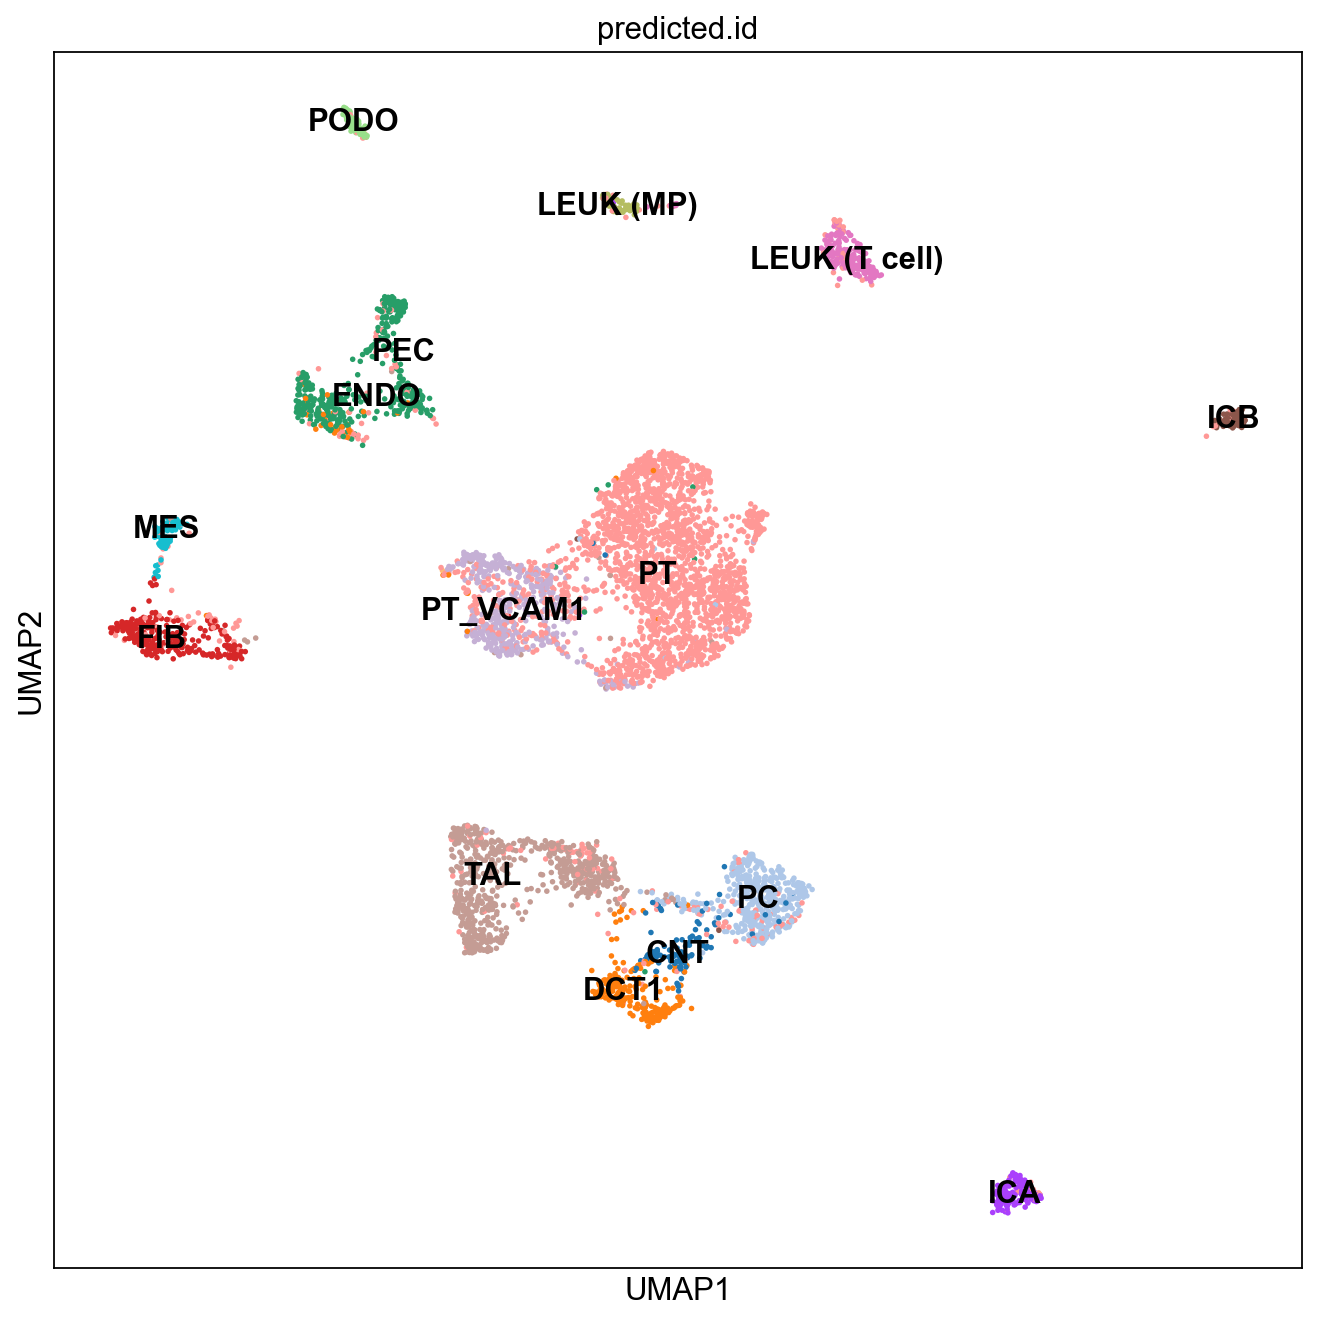

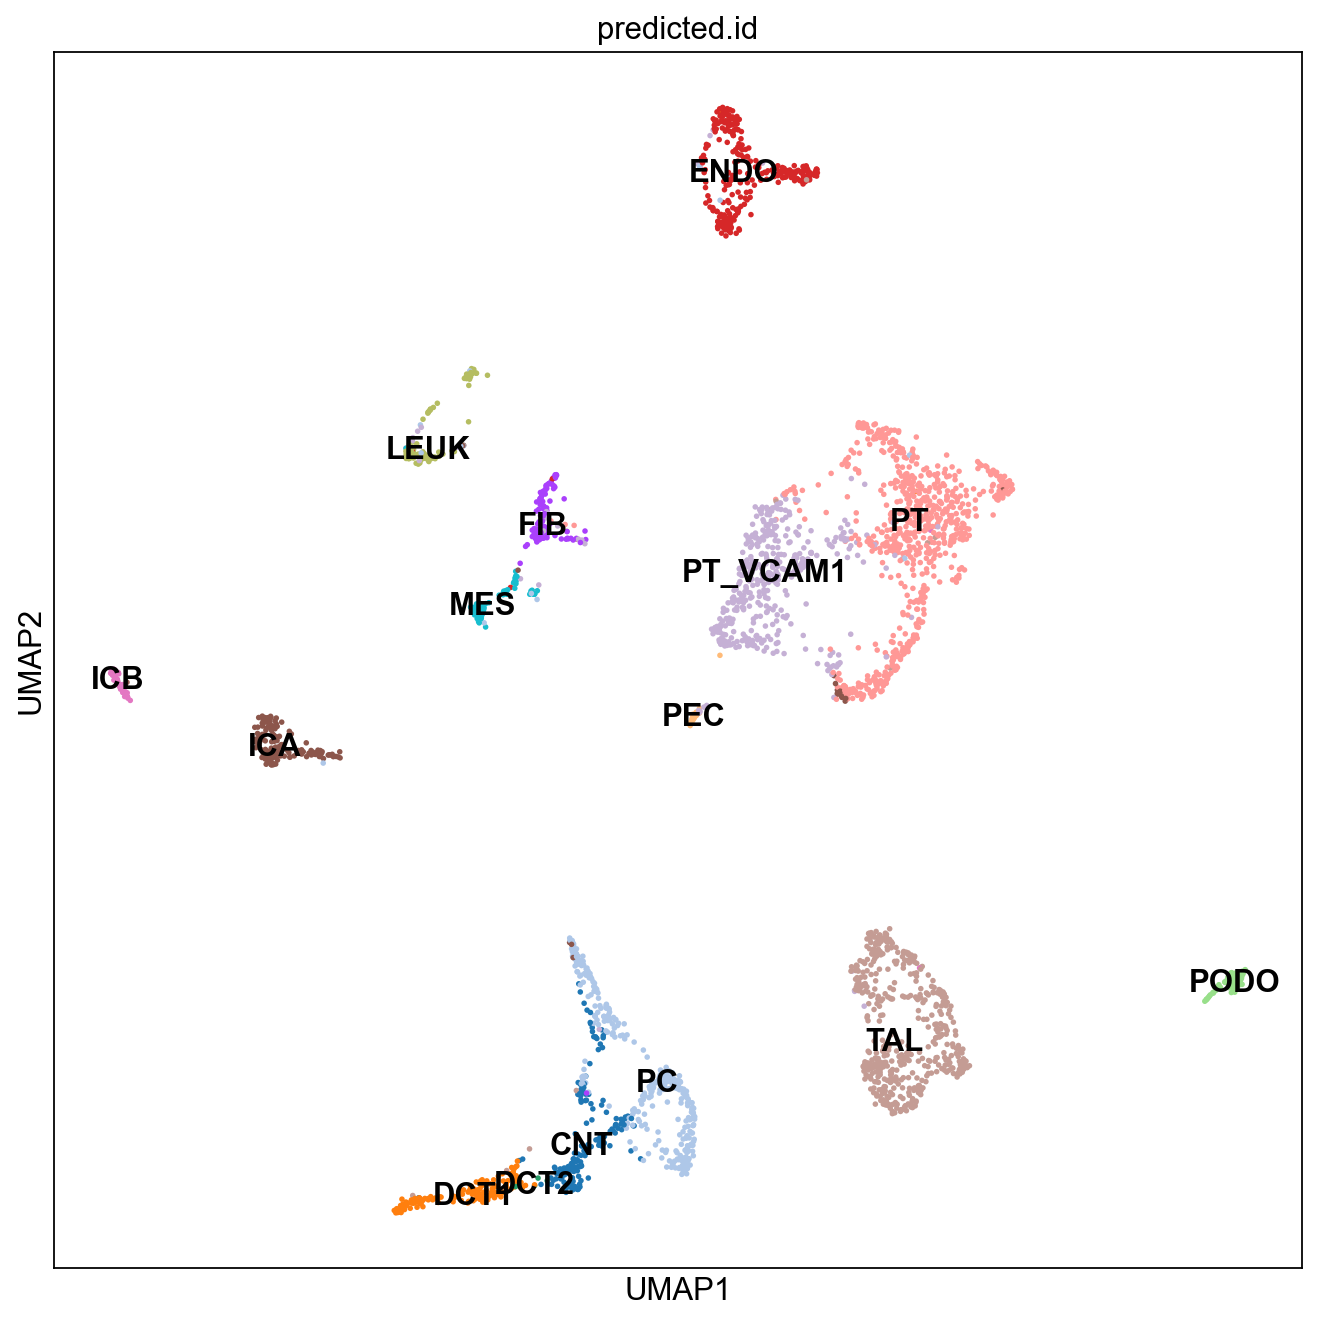

In [3]:
sc.settings.set_figure_params(figsize=('10', '10'), color_map='gist_earth')
# Load and process the reference

atac_peaks = sc.read_h5ad("/home/pab/projects/kidney/Atac/kidney.atac_combpeaks_peaks.h5ad")
atac_peaks.var_names_make_unique()
sc.pp.normalize_total(atac_peaks, target_sum=1e4)
sc.pp.log1p(atac_peaks)

atac_geneact = sc.read_h5ad("/home/pab/projects/kidney/Atac/kidney.atac_combpeaks_RNA.h5ad")
atac_geneact.var_names_make_unique()
sc.pp.normalize_total(atac_geneact, target_sum=1e4)
sc.pp.log1p(atac_geneact)
sc.pl.umap(atac_geneact, color='predicted.id', legend_loc = 'on data', size = 25)

multi_peaks = sc.read_h5ad("/home/pab/projects/kidney/Multi/kidney.multi_combpeaks_peaks.h5ad")
multi_peaks.var_names_make_unique()
sc.pp.normalize_total(multi_peaks, target_sum=1e4)
sc.pp.log1p(multi_peaks)

multi_rna = sc.read_h5ad("/home/pab/projects/kidney/Multi/kidney.multi_combpeaks_RNA.h5ad")
multi_rna.var_names_make_unique()
sc.pp.normalize_total(multi_rna, target_sum=1e4)
sc.pp.log1p(multi_rna)
sc.pl.umap(multi_rna, color='predicted.id', legend_loc = 'on data', size = 25)

In [4]:
sc.tl.rank_genes_groups(multi_rna, groupby="annotation")
top_markers(multi_rna)

,CNT,DCT1,DCT2,ENDO,FIB,ICA,ICB,LEUK,MES,PC,PEC,PODO,PT,PT_VCAM1,TAL
0,AC019197.1,MALAT1,ETNK1,PLPP1,RBMS3,CLNK,CA12,ARHGAP15,PRKG1,PDE10A,SYNE1,PLA2R1,ACSM2B,RHEX,SLC12A1
1,PDE4D,SLC12A3,AC019197.1,MEIS2,CALD1,ADGRF5,CA8,CELF2,RBMS3,MECOM,ALDH1A2,MAGI2,CUBN,PTPRD,ERBB4
2,MECOM,RNPC3,CCSER1,PTPRM,C7,PDE1C,SLC4A9,IKZF1,EBF1,CCSER1,LINC01435,PTPRO,ACSM2A,BNC2,CASR
3,PRKG1,ERBB4,AC138123.1,EMCN,NR2F2-AS1,PACRG,MAGI3,ANKRD44,PIP5K1B,PRKAG2,FRMD4A,PTPRQ,AC096577.1,ITGB8,CCSER1
4,ESRRG,FMN1,ESRRG,PTPRB,PRKG1,SLC26A7,ADAMTSL3,PTPRC,CALD1,ABTB2,FBXL7,COL4A3,PTH2R,UGT2B7,PLCB1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CHPT1,PTPN4,CCDC198,PLPP3,LDLRAD4,AP000282.1,HPSE,SP140,PTEN,SH3BP5,PAG1,GRK5,ZNF804B,ABCC4,PPM1E
96,TBC1D9,TBC1D9,EFNA5,NCOA3,TANC1,CNTNAP5,PLCL1,PIK3R1,ARHGAP26,HOXB3,RBMS3,CERS6,LINC01515,LYPLAL1,CA12
97,NRCAM,AC040174.1,WSB1,PLAT,KIAA1211,PCNX4,BCO2,SLC4A7,TRPM3,FAM107B,ITIH5,CLIP4,GPX3,HAVCR1,WNK4
98,BABAM2,ELOVL7,ZNF704,PIP4K2A,PLA2G4A,UST,AL589693.1,SKAP1,EDIL3,NDRG1,PHLDB1,AC092813.2,RMST,MPP6,DANT2


# Using the multiome RNA and the gene activity inferred from ATAC

### Find common features between the two datasets and filter the others:

In [5]:
multi_rna, atac_geneact = find_common_genes(multi_rna, atac_geneact, target_n_genes=3000)

Dimensions before filtering: (3243, 36601) and (5638, 19607)

Looking for 5000 HVG
Found 1065 genes in common
Looking for 6000 HVG
Found 1418 genes in common
Looking for 7000 HVG
Found 1829 genes in common
Looking for 8000 HVG
Found 2320 genes in common
Looking for 9000 HVG
Found 2855 genes in common
Looking for 10000 HVG
Found 3444 genes in common
Filtering the data to these features and scaling



Dimensions after filtering: (3243, 3444) and (5638, 3444)


### Prepare the reference data and train model:

In [ ]:
!rm -r logs/*
import imageio
import tensorflow as tf

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

label_key = "annotation"
n_feat = multi_rna.shape[1]
n_labs = len(multi_rna.obs[label_key].cat.categories)
ds = DeepScore(hidden_nodes=[512, 128, 64], n_features=n_feat, 
               n_labels=n_labs, batch_size=32, dropout_rate=0.5, 
               epochs=30, weight_reg=True)

ds.set_reference(multi_rna, label_by=label_key , test_prop=0.2)
ds.train(earlystopping=True, lr_scheduler=scheduler,
         create_gif=True, gif_dataset=atac_geneact)
ds.model.save('data/kidney_rna_model_python')

rm: cannot remove 'logs/*': No such file or directory


2022-03-11 18:44:33.322973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 18:44:33.346763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 18:44:33.347053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 18:44:33.347604: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "deepscore"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3444)              13776     
_________________________________________________________________
dense512 (Dense)             (None, 512)               1763840   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense128 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               51

2022-03-11 18:44:34.205929: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 18:44:34.205952: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-11 18:44:34.206953: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-11 18:44:34.527383: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 18:44:34.528952: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-11 18:44:34.594110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
 1/73 [..............................] - ETA: 1:42 - loss: 3.6937 - categorical_accuracy: 0.0625

2022-03-11 18:44:36.055321: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 18:44:36.055343: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


31/73 [===========>..................] - ETA: 0s - loss: 3.0343 - categorical_accuracy: 0.1310

2022-03-11 18:44:36.423034: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-11 18:44:36.424409: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-11 18:44:36.448981: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 289 callback api events and 286 activity events. 
2022-03-11 18:44:36.454811: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 18:44:36.465071: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./deepscore_logs/train/plugins/profile/2022_03_11_18_44_36

2022-03-11 18:44:36.469968: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./deepscore_logs/train/plugins/profile/2022_03_11_18_44_36/kino.trace.json.gz
2022-03-11 18:44:36.483459: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory:

73/73 [==============================] - 2s 12ms/step - loss: 2.5948 - categorical_accuracy: 0.2395 - val_loss: 1.0001 - val_categorical_accuracy: 0.7923


... storing 'Deepscore' as categorical


Epoch 2/30
73/73 [==============================] - 0s 4ms/step - loss: 1.5663 - categorical_accuracy: 0.5497 - val_loss: 0.5334 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 3/30
73/73 [==============================] - 0s 4ms/step - loss: 1.1599 - categorical_accuracy: 0.6722 - val_loss: 0.3902 - val_categorical_accuracy: 0.9038


... storing 'Deepscore' as categorical


Epoch 4/30
73/73 [==============================] - 0s 4ms/step - loss: 0.9284 - categorical_accuracy: 0.7391 - val_loss: 0.3212 - val_categorical_accuracy: 0.9231


... storing 'Deepscore' as categorical


Epoch 5/30
73/73 [==============================] - 0s 4ms/step - loss: 0.7447 - categorical_accuracy: 0.7943 - val_loss: 0.2905 - val_categorical_accuracy: 0.9154


... storing 'Deepscore' as categorical


Epoch 6/30
73/73 [==============================] - 0s 4ms/step - loss: 0.6153 - categorical_accuracy: 0.8273 - val_loss: 0.2736 - val_categorical_accuracy: 0.9269


... storing 'Deepscore' as categorical


Epoch 7/30
73/73 [==============================] - 0s 4ms/step - loss: 0.5366 - categorical_accuracy: 0.8496 - val_loss: 0.2723 - val_categorical_accuracy: 0.9192


... storing 'Deepscore' as categorical


Epoch 8/30
73/73 [==============================] - 0s 4ms/step - loss: 0.4683 - categorical_accuracy: 0.8706 - val_loss: 0.2748 - val_categorical_accuracy: 0.9269


... storing 'Deepscore' as categorical


Epoch 9/30
73/73 [==============================] - 0s 4ms/step - loss: 0.4202 - categorical_accuracy: 0.8890 - val_loss: 0.2636 - val_categorical_accuracy: 0.9269


... storing 'Deepscore' as categorical


Epoch 10/30
73/73 [==============================] - 0s 4ms/step - loss: 0.3483 - categorical_accuracy: 0.9100 - val_loss: 0.2926 - val_categorical_accuracy: 0.9231


... storing 'Deepscore' as categorical


Epoch 11/30
73/73 [==============================] - 0s 4ms/step - loss: 0.3317 - categorical_accuracy: 0.9147 - val_loss: 0.3031 - val_categorical_accuracy: 0.9154


... storing 'Deepscore' as categorical


Epoch 12/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2745 - categorical_accuracy: 0.9293 - val_loss: 0.3048 - val_categorical_accuracy: 0.9115


... storing 'Deepscore' as categorical


Epoch 13/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2617 - categorical_accuracy: 0.9319 - val_loss: 0.3184 - val_categorical_accuracy: 0.9192


... storing 'Deepscore' as categorical


Epoch 14/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2390 - categorical_accuracy: 0.9392 - val_loss: 0.3281 - val_categorical_accuracy: 0.9154


... storing 'Deepscore' as categorical


Epoch 15/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2421 - categorical_accuracy: 0.9357 - val_loss: 0.3423 - val_categorical_accuracy: 0.9077


... storing 'Deepscore' as categorical


Epoch 16/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2070 - categorical_accuracy: 0.9426 - val_loss: 0.3649 - val_categorical_accuracy: 0.9154


... storing 'Deepscore' as categorical


Epoch 17/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1951 - categorical_accuracy: 0.9494 - val_loss: 0.3779 - val_categorical_accuracy: 0.9077


... storing 'Deepscore' as categorical


Epoch 18/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1830 - categorical_accuracy: 0.9537 - val_loss: 0.3937 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 19/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1850 - categorical_accuracy: 0.9486 - val_loss: 0.3922 - val_categorical_accuracy: 0.9000


... storing 'Deepscore' as categorical


Epoch 20/30
73/73 [==============================] - 0s 3ms/step - loss: 0.1665 - categorical_accuracy: 0.9589 - val_loss: 0.3889 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 21/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1744 - categorical_accuracy: 0.9610 - val_loss: 0.3902 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 22/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1621 - categorical_accuracy: 0.9606 - val_loss: 0.4057 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 23/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1374 - categorical_accuracy: 0.9666 - val_loss: 0.4057 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 24/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1641 - categorical_accuracy: 0.9597 - val_loss: 0.4101 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


Epoch 25/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1535 - categorical_accuracy: 0.9580 - val_loss: 0.4205 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 26/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1383 - categorical_accuracy: 0.9692 - val_loss: 0.4318 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 27/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1314 - categorical_accuracy: 0.9679 - val_loss: 0.4379 - val_categorical_accuracy: 0.8923


... storing 'Deepscore' as categorical


Epoch 28/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1293 - categorical_accuracy: 0.9670 - val_loss: 0.4336 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 29/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1463 - categorical_accuracy: 0.9606 - val_loss: 0.4337 - val_categorical_accuracy: 0.8962


... storing 'Deepscore' as categorical


Epoch 30/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1322 - categorical_accuracy: 0.9674 - val_loss: 0.4324 - val_categorical_accuracy: 0.8885


... storing 'Deepscore' as categorical


figures/umap_ds_training0.png
figures/umap_ds_training1.png
figures/umap_ds_training2.png
figures/umap_ds_training3.png
figures/umap_ds_training4.png
figures/umap_ds_training5.png
figures/umap_ds_training6.png
figures/umap_ds_training7.png
figures/umap_ds_training8.png
figures/umap_ds_training9.png
figures/umap_ds_training10.png
figures/umap_ds_training11.png
figures/umap_ds_training12.png
figures/umap_ds_training13.png
figures/umap_ds_training14.png
figures/umap_ds_training15.png
figures/umap_ds_training16.png
figures/umap_ds_training17.png
figures/umap_ds_training18.png
figures/umap_ds_training19.png
figures/umap_ds_training20.png
figures/umap_ds_training21.png
figures/umap_ds_training22.png
figures/umap_ds_training23.png
figures/umap_ds_training24.png
figures/umap_ds_training25.png
figures/umap_ds_training26.png
figures/umap_ds_training27.png
figures/umap_ds_training28.png
figures/umap_ds_training29.png

Evaluating model performance on unseen data (test data):

21/21 [==============

2022-03-11 18:45:21.919986: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/kidney_rna_model_python/assets


### Predict the celltypes in our sample using the trained model:

... storing 'Deepscore' as categorical


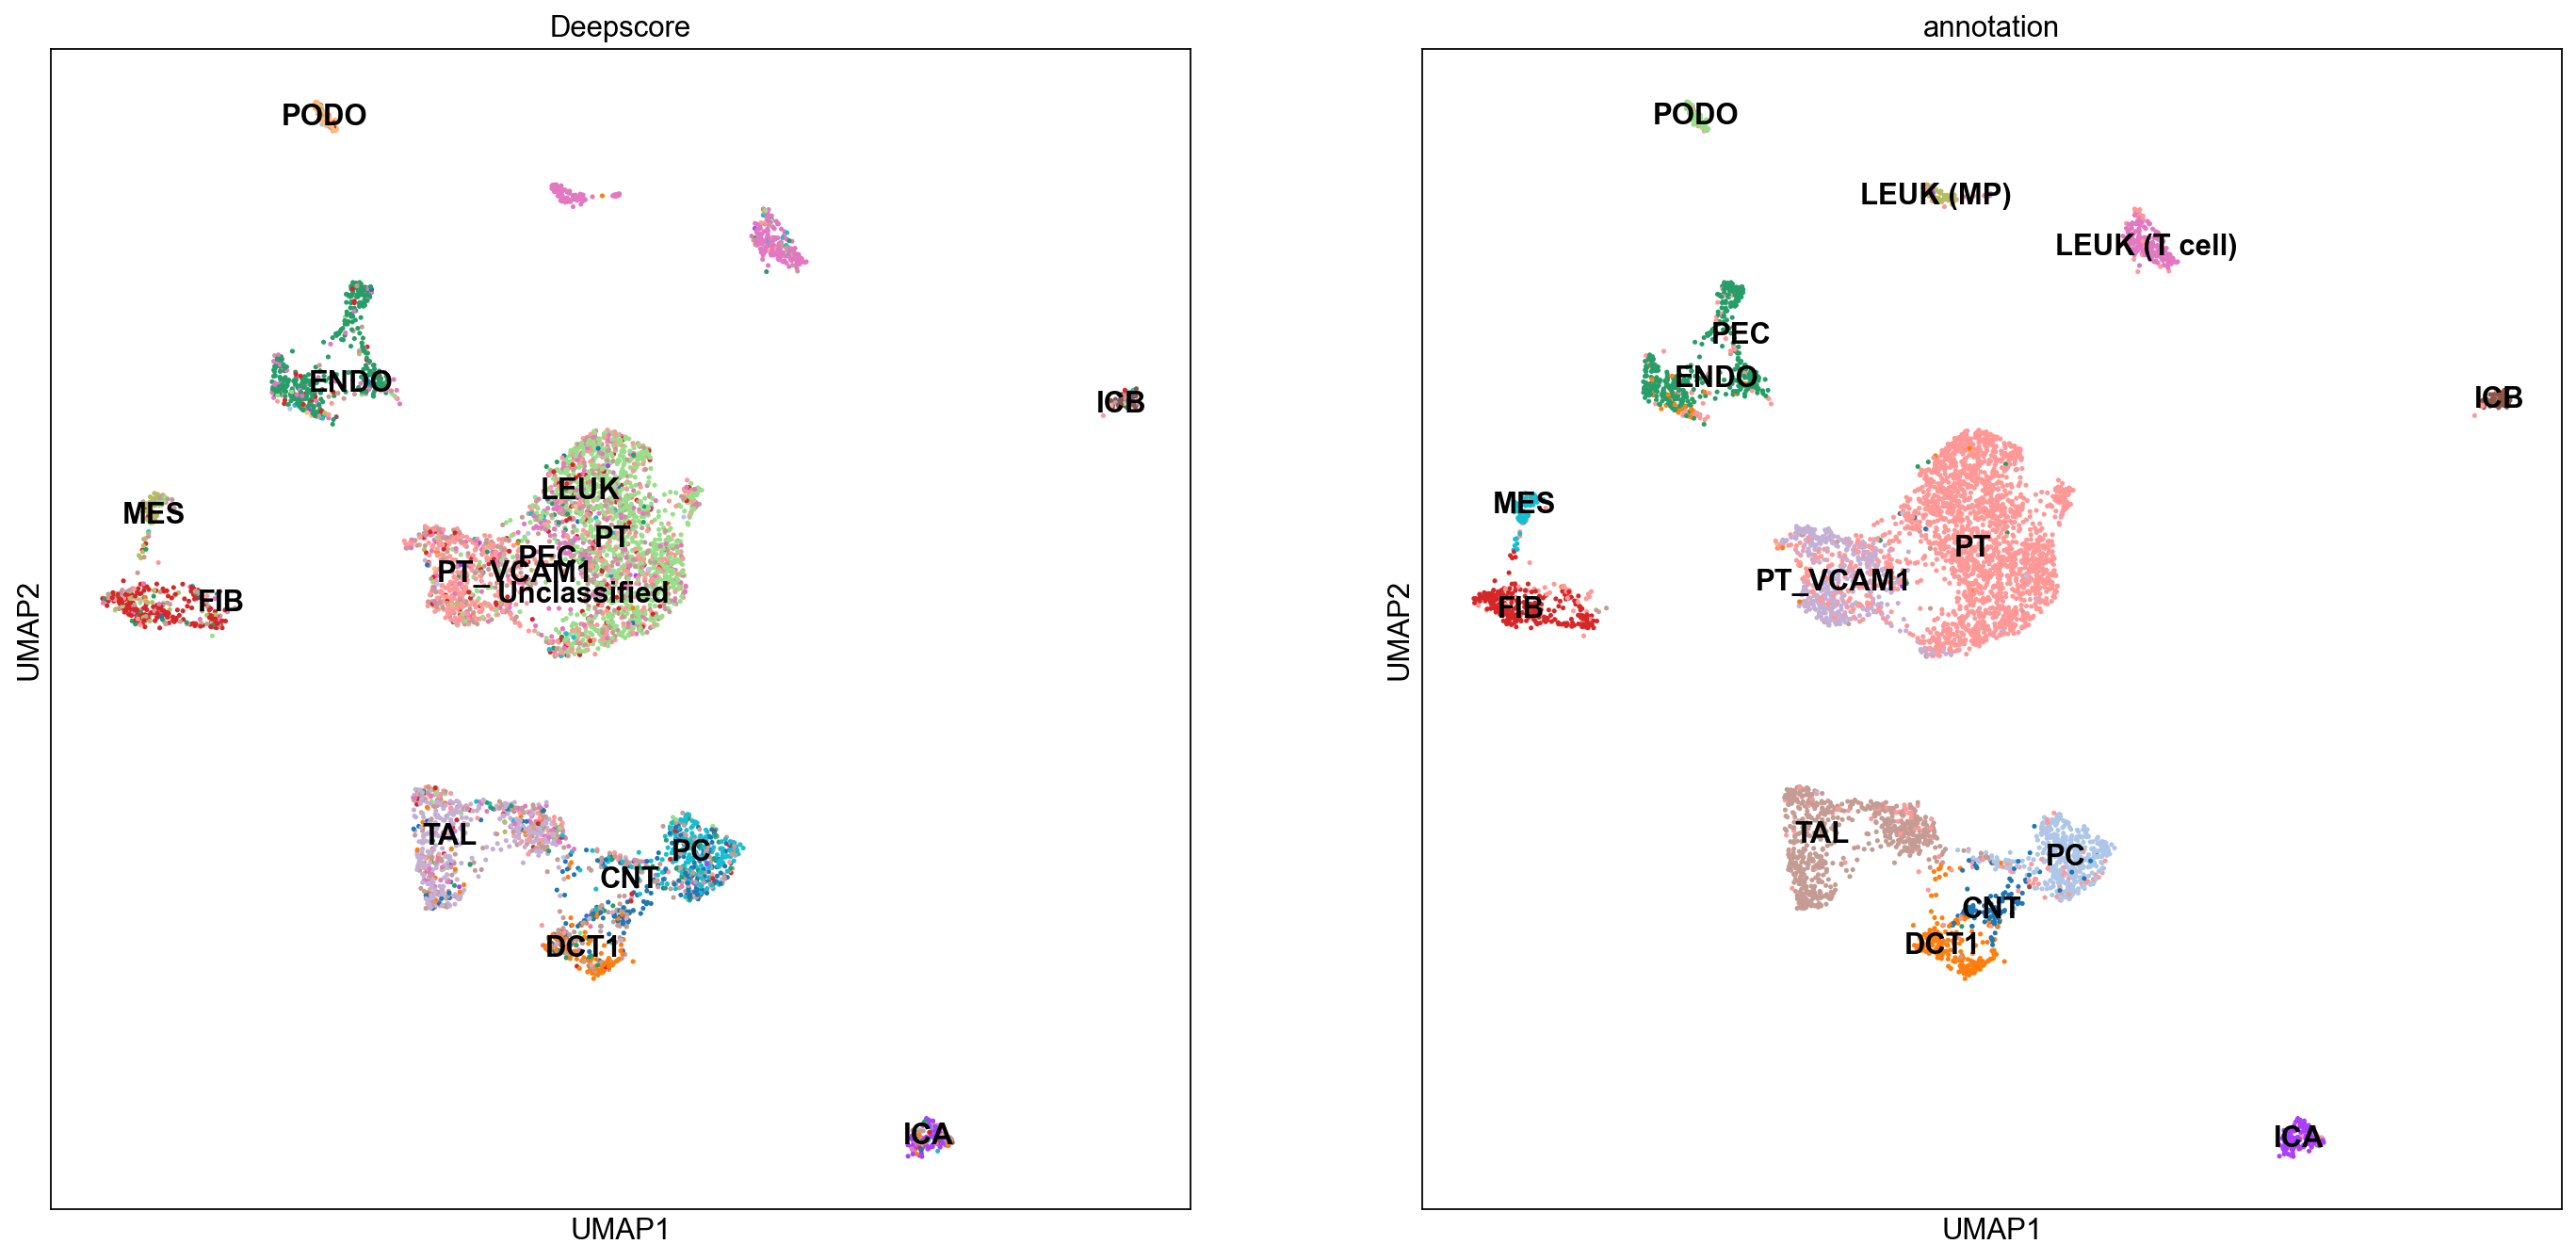

In [7]:
atac_geneact = ds.annotate(atac_geneact)
sc.pl.umap(atac_geneact, color=['Deepscore', 'annotation'], legend_loc='on data')

In [8]:
sc.tl.rank_genes_groups(multi_rna, 'annotation', method='logreg')
sc.tl.rank_genes_groups(atac_geneact, 'Deepscore', method='logreg')

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [9]:
ref_markers = top_markers(multi_rna, ntop=100)
sample_markers = top_markers(atac_geneact, ntop=100)
ref_markers.head(5), sample_markers.head(5)

(       CNT      DCT1     DCT2    ENDO       FIB       ICA      ICB    LEUK  \
 0    CALB1   SLC12A3    TRPM6  SHANK3        C7      CLNK   SLC4A9   IKZF1   
 1    SCN2A  ADAMTS17   LSMEM2    EMCN     SVEP1   SLC26A7  SLC26A4  PIK3R5   
 2     SOX5     SALL3  GPR137C    XAF1  CRISPLD2  MTRNR2L1      CA8   SMAP2   
 3  PIK3C2G     RNPC3  SLC12A3     TEK     ABCC9    ADGRF5    INSRR  TBXAS1   
 4    SYNPR   TMEM52B     EGR3   PLPP1     ABCA8     NXPH2     SACS   CXCR4   
 
         MES       PC    PEC    PODO        PT PT_VCAM1      TAL  
 0   COL25A1    GATA3    CFH   PTPRO  EBNA1BP2   KCTD16  SLC12A1  
 1     WFDC1    FXYD4  WSCD2   PTPRQ       PLG   DOCK11     CASR  
 2   PIP5K1B      TOX  KCNT2   NPHS1       AFM  COL27A1     SIM2  
 3  TMEM132C  ST6GAL1  EDIL3   NPHS2     PDZD2  RHOBTB1     UMOD  
 4     AGTR1   ATP1B3   OCA2  PLA2R1    SLC4A4   CAPN12      GP2  ,
         CNT     DCT1      ENDO       FIB       ICA       ICB     LEUK  \
 0      DSG3  C3orf84  C17orf98     VN1R2      

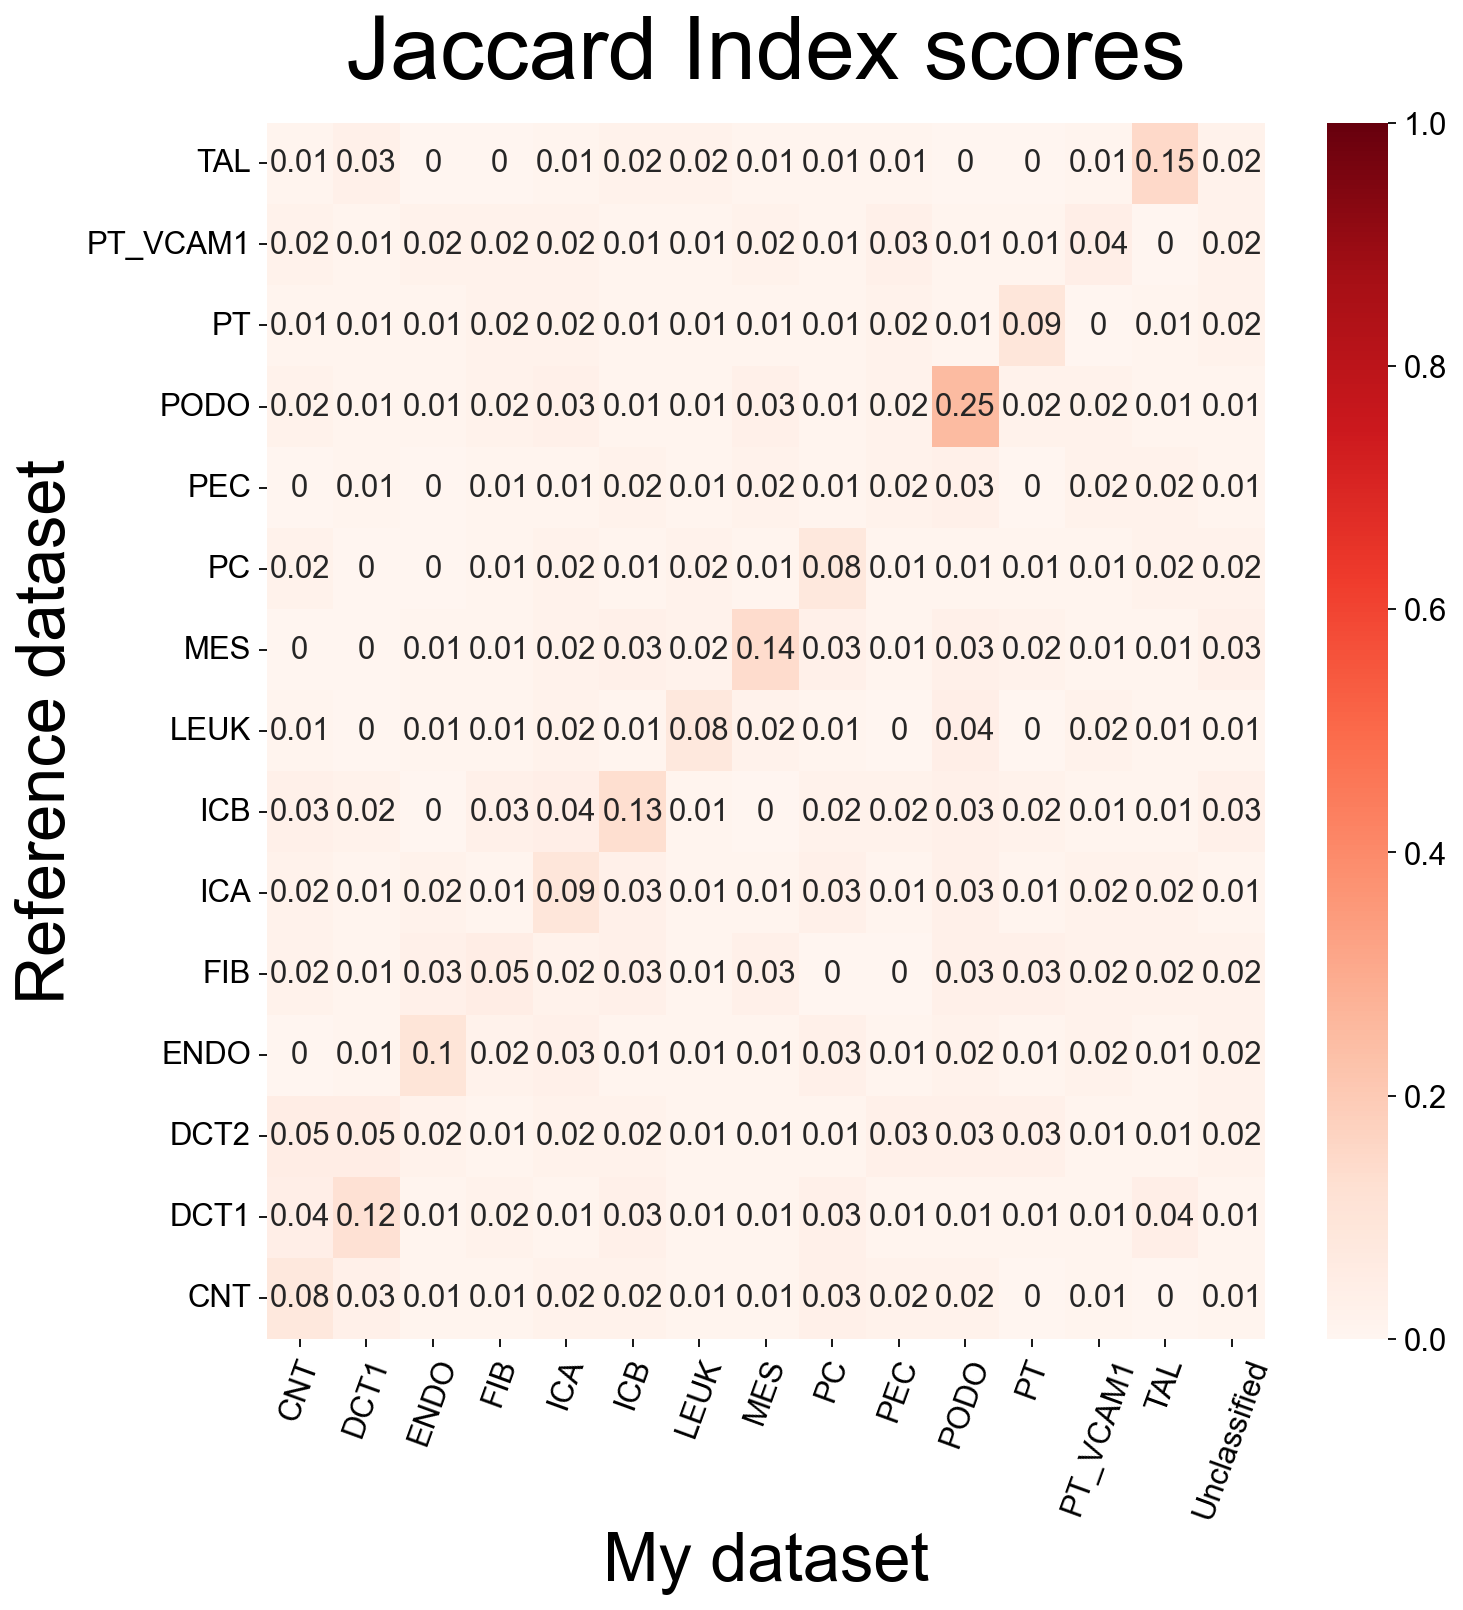

In [10]:
ms = matchscore(ref_markers, sample_markers, plot=True)

# Using the multiome peaks and the ATAC peaks